# Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import pandas as pd
import seaborn as sns
import os
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, History
from sklearn.metrics import classification_report

from os.path import exists


Using TensorFlow backend.


# Creating a Dictionary of Images and their Labels

In [2]:
base_skin_dir = '.\\Documents\\Datasets\\'

In [3]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
print(len(imageid_path_dict))

10015


In [4]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Load MetaData

In [5]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata'))

In [6]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get) #Image Local Path
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) #Full 'dx' name
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes #Unique code for each 'dx'

In [7]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,.\Documents\Datasets\HAM10000_images_part_2\IS...,Benign keratosis-like lesions,2


In [8]:
len(skin_df)

10015

# Cleaning Dataset

In [9]:
skin_df = skin_df.drop_duplicates(subset='lesion_id')
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,.\Documents\Datasets\HAM10000_images_part_2\IS...,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2


 # Processing and Resizing Images

In [10]:
width = 224
height = 224
print("Width: ", width)
print("Height:", height)

Width:  224
Height: 224


In [11]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((int(width), int(height)))))

In [12]:
skin_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2,"[[[187, 152, 194], [190, 155, 197], [192, 155,..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2,"[[[185, 126, 132], [188, 128, 136], [191, 135,..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,.\Documents\Datasets\HAM10000_images_part_2\IS...,Benign keratosis-like lesions,2,"[[[126, 84, 106], [133, 91, 113], [140, 92, 11..."
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2,"[[[194, 143, 124], [188, 145, 129], [192, 144,..."
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2,"[[[95, 61, 60], [102, 66, 66], [105, 71, 70], ..."


In [13]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    7470
Name: image, dtype: int64

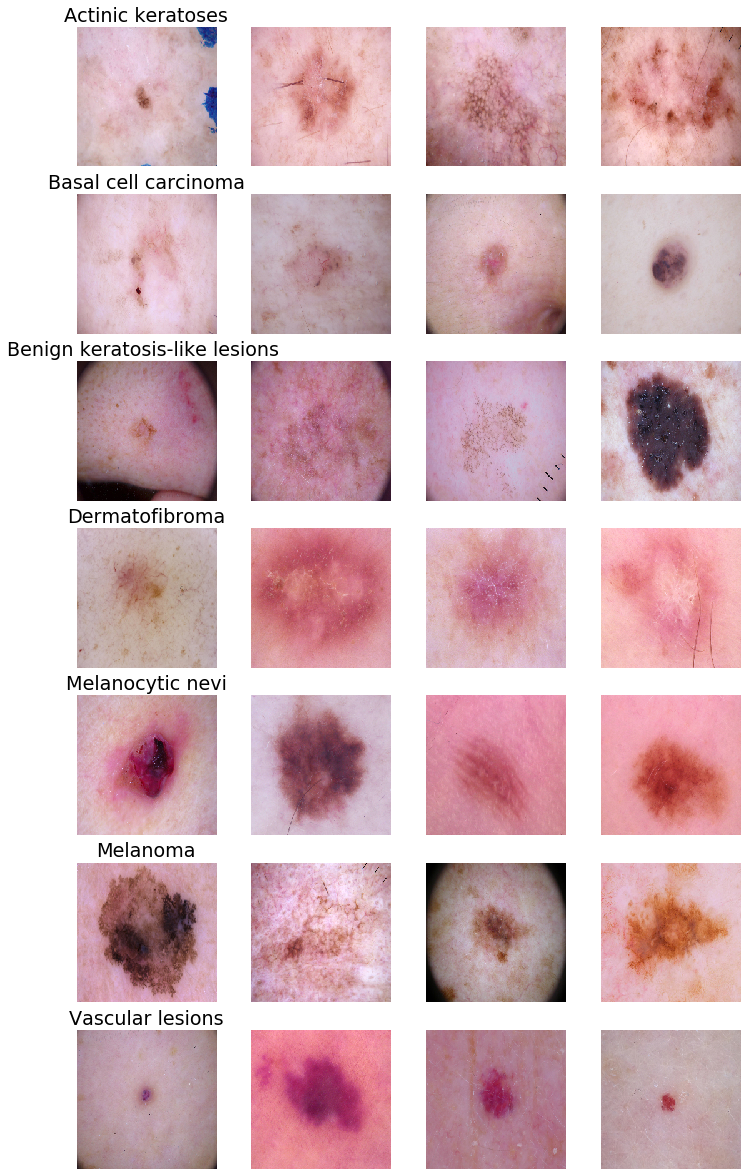

In [20]:
n_samples = 4
fig, m_axs = plt.subplots(7, n_samples, figsize = (3*n_samples, 3*7))
plt.rcParams['font.size'] = 16

for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

if not exists('Photos2'):
    os.mkdir('Photos2')
fig.savefig('.//Photos2//category_samples3.png', dpi=300)

# Features and Target Split

In [25]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# UnderSampling

In [26]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
features, target = under_sampler.fit_resample(features, target)

# To Categorical

In [27]:
num_classes = 7
target_encoded = to_categorical(target, num_classes = num_classes)
print(target_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


# Training, Validation, and Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.20, stratify=target_encoded)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

In [30]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

326
103
82


# Feature Normalization

In [31]:
x_train_images = np.asarray(X_train['image'].tolist())
x_val_images = np.asarray(X_val['image'].tolist())
x_test_images = np.asarray(X_test['image'].tolist())

x_train_mean = np.mean(x_train_images)
x_train_std = np.std(x_train_images)

x_train_normalized = (x_train_images - x_train_mean)/x_train_std
x_val_normalized = (x_val_images - x_train_mean)/x_train_std
x_test_normalized = (x_test_images - x_train_mean)/x_train_std

# Reshaping Images

In [32]:
input_shape = (int(width), int(height), 3)
x_train_normalized = x_train_normalized.reshape(x_train_normalized.shape[0], * (input_shape))
x_val_normalized = x_val_normalized.reshape(x_val_normalized.shape[0], * (input_shape))
x_test_normalized = x_test_normalized.reshape(x_test_normalized.shape[0], * (input_shape))

# Data Augmentation

In [33]:
augmented_data = ImageDataGenerator(featurewise_center=False, 
                                    samplewise_center=False, 
                                    featurewise_std_normalization=False, 
                                    samplewise_std_normalization=False, 
                                    zca_whitening=False, 
                                    zca_epsilon=1e-06, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    brightness_range=None, 
                                    shear_range=0.1, 
                                    zoom_range=0.1, 
                                    channel_shift_range=0.1, 
                                    fill_mode='nearest', 
                                    cval=0.0, 
                                    horizontal_flip=False, 
                                    vertical_flip=False, 
                                    rescale=None, 
                                    preprocessing_function=None, 
                                    data_format='channels_last')

# Create a CNN Model

In [34]:
inputs=Input((224, 224, 3))
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(inputs)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);
x = Dropout(0.25)(x)

x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(7, activation="softmax")(x)
    
model1 = Model(inputs, outputs)
model1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 128)       0   

# Create a Pre-train VGG16 Model

In [35]:
basemodel = VGG16(input_shape=(width, height, 3), include_top = False)
basemodel.summary()
    
for layer in basemodel.layers:
    layer.trainable = False
     
inputs = basemodel.input   
x = basemodel.output
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(7, activation='softmax')(x)
model2 = Model(inputs, outputs)
model2.summary()
    

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Create a Pre-train MobileNetV2

In [36]:
mobile = MobileNetV2(input_shape=(height, width, 3), include_top = False)
mobile.summary()

inputs = mobile.input;
x = mobile.layers[-6].output
x = Dropout(0.25)(x)
x = Flatten()(x)
outputs = Dense(7, activation='softmax')(x)
model3 = Model(inputs, outputs)
model3.summary()

for layer in model3.layers[:-23]:
    layer.trainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

# Create a Pre-train ResNet152V2

In [37]:
basemodel = ResNet152V2(input_shape=(height, width, 3), include_top = False)
basemodel.summary()

for layer in basemodel.layers:
    layer.trainable = False

inputs = basemodel.input;
x = basemodel.output
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(64, activation = 'sigmoid')(x)
outputs = Dense(7, activation='softmax')(x)
model4 = Model(inputs, outputs)
model4.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

# Set Batch Size 

In [38]:
num_train_samples = len(x_train_normalized)
num_val_samples = len(x_val_normalized)
train_batch_size = 32
val_batch_size = 32

train_batches = augmented_data.flow(x_train_normalized, y_train, batch_size = train_batch_size)

valid_batches = augmented_data.flow(x_val_normalized, y_val, batch_size = val_batch_size)

test_batches = augmented_data.flow(x_test_normalized, y_test, batch_size = 1)

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

# Training and Testing and Predicted Data Using AM-12

In [39]:
# Train model
model1.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_accuracy', patience = 10)]
history1 = model1.fit(train_batches, steps_per_epoch=train_steps,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11.0 steps, validate for 3.0 steps
Epoch 1/50
11/11 [==============================] - 71s 6s/step - loss: 1.9760 - accuracy: 0.1166 - mse: 0.1236 - val_loss: 1.9452 - val_accuracy: 0.1220 - val_mse: 0.1224
Epoch 2/50
11/11 [==============================] - 68s 6s/step - loss: 1.9385 - accuracy: 0.1196 - mse: 0.1221 - val_loss: 1.9484 - val_accuracy: 0.1098 - val_mse: 0.1226
Epoch 3/50
11/11 [==============================] - 68s 6s/step - loss: 1.9058 - accuracy: 0.1840 - mse: 0.1210 - val_loss: 1.9474 - val_accuracy: 0.1951 - val_mse: 0.1228
Epoch 4/50
11/11 [==============================] - 70s 6s/step - loss: 1.9313 - accuracy: 0.2147 - mse: 0.1221 - val_loss: 1.9419 - val_accuracy: 0.2073 - val_mse: 0.1224
Epoch 5/50
11/11 [==============================] - 68s 6s/step - loss: 1.8766 - accuracy: 0.2239 - mse: 0.1203 - val_loss: 1.9313 - val_accuracy: 0.1707 - val_mse: 0.1232
Epoch 6/50
11/11 [===========================

In [40]:
if not exists('Models2'):
    os.mkdir('Models2')
model1.save('.//Models2//AM-12_Imbalanced.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


In [41]:
test_loss, test_accuracy, test_mse = model1.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

  ...
    to  
  ['...']
103/103 [==============================] - 6s 59ms/step - loss: 1.5708 - accuracy: 0.4757 - mse: 0.1011

Test Set Accuracy:  47.57281541824341 % 
Test Set Loss: 1.5707947930619517 
Test Set MSE: 0.101051174


# Training and Testing and Predicted Data Using VGG16

In [42]:
# Train model
model2.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_accuracy', patience = 10)]
history2 = model2.fit(train_batches, steps_per_epoch=train_steps,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11.0 steps, validate for 3.0 steps
Epoch 1/50
11/11 [==============================] - 53s 5s/step - loss: 2.7256 - accuracy: 0.1963 - mse: 0.1446 - val_loss: 1.8811 - val_accuracy: 0.2561 - val_mse: 0.1201
Epoch 2/50
11/11 [==============================] - 52s 5s/step - loss: 1.7555 - accuracy: 0.3436 - mse: 0.1114 - val_loss: 1.7992 - val_accuracy: 0.3659 - val_mse: 0.1131
Epoch 3/50
11/11 [==============================] - 51s 5s/step - loss: 1.4824 - accuracy: 0.4325 - mse: 0.1001 - val_loss: 1.7117 - val_accuracy: 0.3293 - val_mse: 0.1106
Epoch 4/50
11/11 [==============================] - 53s 5s/step - loss: 1.3915 - accuracy: 0.4724 - mse: 0.0925 - val_loss: 1.7858 - val_accuracy: 0.3902 - val_mse: 0.1113
Epoch 5/50
11/11 [==============================] - 52s 5s/step - loss: 1.2520 - accuracy: 0.4969 - mse: 0.0877 - val_loss: 1.8158 - val_accuracy: 0.3659 - val_mse: 0.1152
Epoch 6/50
11/11 [===========================

11/11 [==============================] - 52s 5s/step - loss: 0.2028 - accuracy: 0.9264 - mse: 0.0151 - val_loss: 2.0829 - val_accuracy: 0.5000 - val_mse: 0.1059
Epoch 48/50
11/11 [==============================] - 52s 5s/step - loss: 0.1522 - accuracy: 0.9571 - mse: 0.0101 - val_loss: 1.9202 - val_accuracy: 0.4390 - val_mse: 0.1117
Epoch 49/50
11/11 [==============================] - 52s 5s/step - loss: 0.1740 - accuracy: 0.9417 - mse: 0.0127 - val_loss: 1.9299 - val_accuracy: 0.4878 - val_mse: 0.1068
Epoch 50/50
11/11 [==============================] - 52s 5s/step - loss: 0.1675 - accuracy: 0.9479 - mse: 0.0122 - val_loss: 2.1849 - val_accuracy: 0.4268 - val_mse: 0.1171


In [44]:
if not exists('Models2'):
    os.mkdir('Models2')
model1.save('.//Models2//VGG16_Imbalanced.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


In [43]:
test_loss, test_accuracy, test_mse = model2.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

  ...
    to  
  ['...']
103/103 [==============================] - 13s 125ms/step - loss: 1.5478 - accuracy: 0.6019 - mse: 0.0891

Test Set Accuracy:  60.19417643547058 % 
Test Set Loss: 1.5477792569345028 
Test Set MSE: 0.08905967


# Training and Testing and Predicted Data Using MobileNetV2

In [45]:
# Train model
model3.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_accuracy', patience = 10)]
history3= model3.fit(train_batches, steps_per_epoch=train_steps,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11.0 steps, validate for 3.0 steps
Epoch 1/10
11/11 [==============================] - 41s 4s/step - loss: 26.3991 - accuracy: 0.1534 - mse: 0.2177 - val_loss: 12.5661 - val_accuracy: 0.1829 - val_mse: 0.2081
Epoch 2/10
11/11 [==============================] - 37s 3s/step - loss: 13.9765 - accuracy: 0.3681 - mse: 0.1581 - val_loss: 19.1359 - val_accuracy: 0.2073 - val_mse: 0.2196
Epoch 3/10
11/11 [==============================] - 37s 3s/step - loss: 4.9336 - accuracy: 0.5031 - mse: 0.1222 - val_loss: 14.8600 - val_accuracy: 0.2683 - val_mse: 0.1962
Epoch 4/10
11/11 [==============================] - 37s 3s/step - loss: 1.9920 - accuracy: 0.6564 - mse: 0.0821 - val_loss: 14.5817 - val_accuracy: 0.3293 - val_mse: 0.1783
Epoch 5/10
11/11 [==============================] - 38s 3s/step - loss: 1.7465 - accuracy: 0.6994 - mse: 0.0742 - val_loss: 16.4018 - val_accuracy: 0.3537 - val_mse: 0.1804
Epoch 6/10
11/11 [====================

In [46]:
if not exists('Models2'):
    os.mkdir('Models2')
model1.save('.//Models2//MobileNetV2_Imbalanced.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


In [47]:
test_loss, test_accuracy, test_mse = model3.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

  ...
    to  
  ['...']
103/103 [==============================] - 3s 27ms/step - loss: 13.9435 - accuracy: 0.3495 - mse: 0.1789

Test Set Accuracy:  34.951457381248474 % 
Test Set Loss: 13.943452753279674 
Test Set MSE: 0.17891736


# Training and Testing and Predicted Data Using ResNet152V2

In [48]:
# Train model
model4.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_accuracy', patience = 10)]
history4 = model4.fit(train_batches, steps_per_epoch=train_steps, 
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=50)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11.0 steps, validate for 3.0 steps
Epoch 1/50
11/11 [==============================] - 172s 16s/step - loss: 2.2191 - accuracy: 0.2055 - mse: 0.1289 - val_loss: 2.1737 - val_accuracy: 0.2073 - val_mse: 0.1274
Epoch 2/50
11/11 [==============================] - 157s 14s/step - loss: 1.7854 - accuracy: 0.3804 - mse: 0.1113 - val_loss: 1.9992 - val_accuracy: 0.2317 - val_mse: 0.1231
Epoch 3/50
11/11 [==============================] - 157s 14s/step - loss: 1.6062 - accuracy: 0.4325 - mse: 0.1052 - val_loss: 2.0506 - val_accuracy: 0.1829 - val_mse: 0.1264
Epoch 4/50
11/11 [==============================] - 153s 14s/step - loss: 1.4829 - accuracy: 0.5061 - mse: 0.0985 - val_loss: 2.0191 - val_accuracy: 0.2317 - val_mse: 0.1250
Epoch 5/50
11/11 [==============================] - 153s 14s/step - loss: 1.3596 - accuracy: 0.6227 - mse: 0.0917 - val_loss: 1.9393 - val_accuracy: 0.2683 - val_mse: 0.1204
Epoch 6/50
11/11 [=================

In [49]:
if not exists('Models2'):
    os.mkdir('Models2')
model1.save('.//Models2//ResNet152V2_Imbalanced.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


In [50]:
test_loss, test_accuracy, test_mse = model4.evaluate(test_batches)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

  ...
    to  
  ['...']
103/103 [==============================] - 18s 172ms/step - loss: 1.9206 - accuracy: 0.2816 - mse: 0.1220

Test Set Accuracy:  28.155338764190674 % 
Test Set Loss: 1.9206377332216327 
Test Set MSE: 0.12196053


# Testing Set Confusion Matrix for True vs Predicted Labels

In [51]:
def cal_true_pred_classes(model, x_test_normalized, y_test):
    #Predict the values from the testing set
    y_predict = model.predict(x_test_normalized)

    #Convert prediction classes to one hot vectors 
    y_predict_classes = np.argmax(y_predict, axis = 1) 

    #Convert testing label observations to one hot vectors
    y_true_classes = np.argmax(y_test, axis = 1) 
    
    return y_predict_classes, y_true_classes

In [53]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.rcParams['font.size'] = 16
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('.//Photos2//' + name + '_confusion_matrix.png', dpi=300)

In [54]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [55]:
#Define the labels of the class indices. These need to match the order shown above.
cm_plot_labels=['akiec', 'bcc', 'bkl', 'df', 'nv','mel', 'vasc']

In [56]:
model1_name = "AM-12"
model2_name = "VGG16"
model3_name = "MobileNetV2"
model4_name = "ResNet152V2"

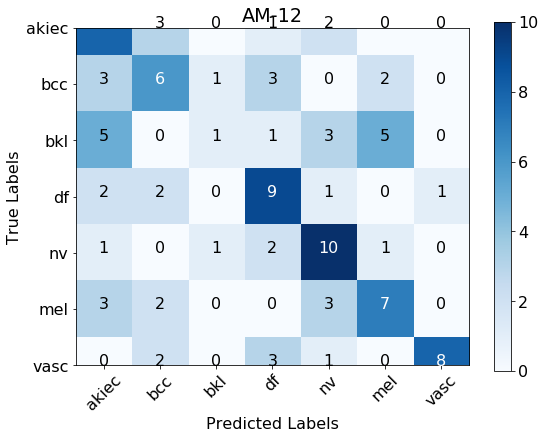

In [57]:
create_confusion_matrix(model1, x_test_normalized, y_test, cm_plot_labels, model1_name)

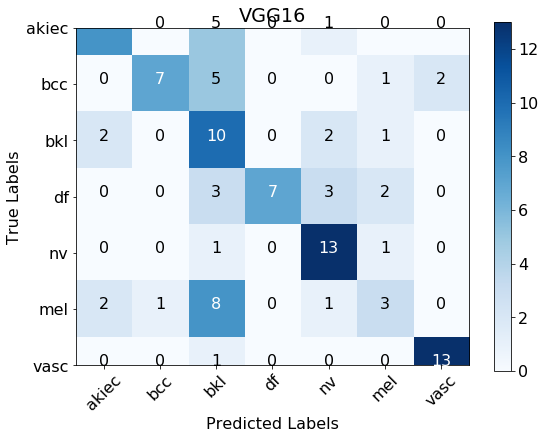

In [58]:
create_confusion_matrix(model2, x_test_normalized, y_test, cm_plot_labels, model2_name)

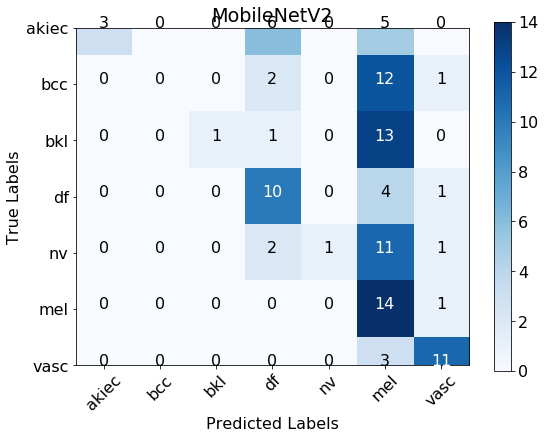

In [59]:
create_confusion_matrix(model3, x_test_normalized, y_test, cm_plot_labels, model3_name)

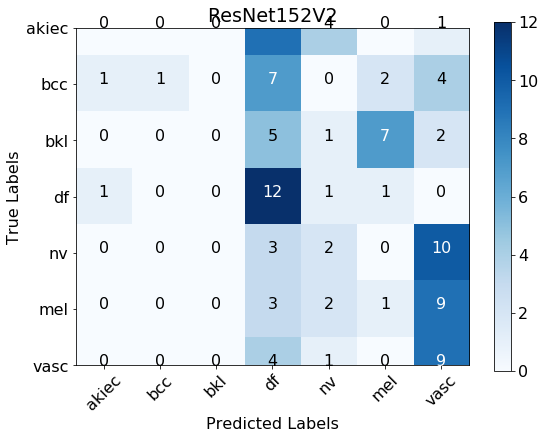

In [60]:
create_confusion_matrix(model4, x_test_normalized, y_test, cm_plot_labels, model4_name)

# Generate a Confusion Matrix Classification Report

In [61]:
def gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels):
    
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
    
    #Generate report
    report = classification_report(y_true_classes, y_predict_classes, target_names = cm_plot_labels)
    print(report)

In [62]:
gen_classification_report(model1, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.36      0.57      0.44        14
         bcc       0.40      0.40      0.40        15
         bkl       0.33      0.07      0.11        15
          df       0.47      0.60      0.53        15
          nv       0.50      0.67      0.57        15
         mel       0.47      0.47      0.47        15
        vasc       0.89      0.57      0.70        14

    accuracy                           0.48       103
   macro avg       0.49      0.48      0.46       103
weighted avg       0.49      0.48      0.46       103



In [63]:
gen_classification_report(model2, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.67      0.57      0.62        14
         bcc       0.88      0.47      0.61        15
         bkl       0.30      0.67      0.42        15
          df       1.00      0.47      0.64        15
          nv       0.65      0.87      0.74        15
         mel       0.38      0.20      0.26        15
        vasc       0.87      0.93      0.90        14

    accuracy                           0.59       103
   macro avg       0.68      0.60      0.60       103
weighted avg       0.67      0.59      0.59       103



In [64]:
gen_classification_report(model3, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       1.00      0.21      0.35        14
         bcc       0.00      0.00      0.00        15
         bkl       1.00      0.07      0.12        15
          df       0.48      0.67      0.56        15
          nv       1.00      0.07      0.12        15
         mel       0.23      0.93      0.36        15
        vasc       0.73      0.79      0.76        14

    accuracy                           0.39       103
   macro avg       0.63      0.39      0.33       103
weighted avg       0.63      0.39      0.32       103



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
gen_classification_report(model4, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        14
         bcc       1.00      0.07      0.12        15
         bkl       0.00      0.00      0.00        15
          df       0.28      0.80      0.41        15
          nv       0.18      0.13      0.15        15
         mel       0.09      0.07      0.08        15
        vasc       0.26      0.64      0.37        14

    accuracy                           0.24       103
   macro avg       0.26      0.24      0.16       103
weighted avg       0.26      0.24      0.16       103



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plot the Models History

In [66]:
def plot_model_history(model_history, name):
    
    fig = plt.figure()

    #Summarize history for accuracy
    ax1 = plt.subplot(1,2,1) 
    ax1.plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    ax1.plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    ax1.legend(['train', 'validation'], loc='best')
    
    #Summarize history for loss
    ax2 = plt.subplot(1,2,2) 
    ax2.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    ax2.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    ax2.legend(['train', 'validation'], loc='best')
    
    #Plot and save figures
    plt.show()
    fig.savefig('.//Photos2//' + name + '_model_history.png', dpi=300)

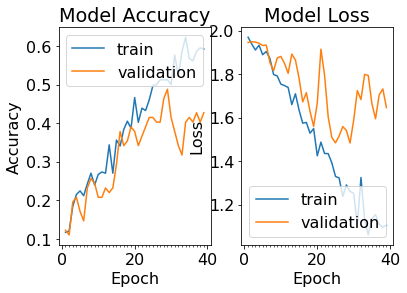

In [67]:
plot_model_history(history1, "AM-12")

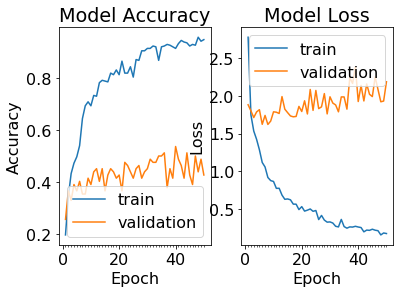

In [68]:
plot_model_history(history2, "VGG16")

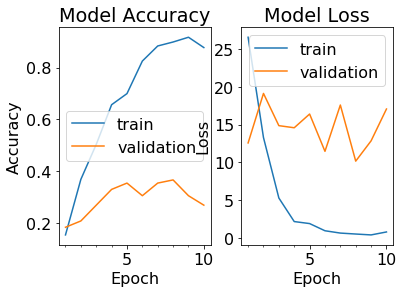

In [69]:
plot_model_history(history3, "MobileNetV2")

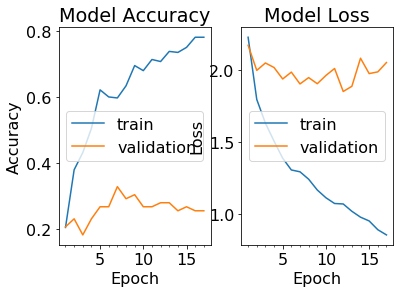

In [70]:
plot_model_history(history4, "ResNet152V2")